In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [68]:
num_imgs = 500

img_size = 16
min_rect_size = 2
max_rect_size = 3
num_objects = 2


bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))
shapes = np.zeros((num_imgs, num_objects, 1))

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        if np.random.choice([True, False]):
            width, height = np.random.randint(min_rect_size, max_rect_size, size=2)
            x = np.random.randint(0, img_size )
            y = np.random.randint(0, img_size )
       #     imgs[i_img, x:x+width, y:y+height] = 1.    #it create box in the image 
       #     bboxes[i_img, i_object] = [x, y, width, height]
       #     shapes[i_img, i_object] = [0]
        else:
            size = np.random.randint(min_rect_size, max_rect_size)
            x, y = np.random.randint(0, img_size - size, size=2)
            mask = np.tril_indices(size) 
            imgs[i_img, x + mask[0], y + mask[1]] = 1.
         #   bboxes[i_img, i_object] = [x, y, size, size]
            shapes[i_img, i_object] = [1]
        
imgs.shape, bboxes.shape

((500, 16, 16), (500, 2, 4))

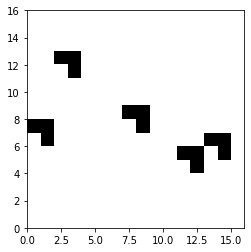

In [70]:
i = 2
# TODO: Why does the array have to be transposed?
plt.imshow(imgs[i].T+imgs[i+1].T+imgs[i+2].T, cmap='Greys', interpolation='none', origin='upper', extent=[0, img_size, 0, img_size])
for bbox, shape in zip(bboxes[i], shapes[0]):
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r' if shape[0] == 0 else 'y', fc='none'))


In [335]:
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

((500, 256), 7.993605777301126e-18, 0.9999999999999998)

In [336]:
# TODO: We use binary classification here - for multiple classes, convert classes to one-hot vectors.
y = np.concatenate([bboxes / img_size, shapes], axis=-1).reshape(num_imgs, -1)
y.shape

(500, 15)

In [337]:
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

In [412]:
# for the estimation of number input layers 
train_X.shape 

(400, 256)

In [425]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
#from keras.optimizers import SGD
from keras.optimizers import gradient_descent_v2 
model = Sequential([
        Dense(32, input_dim=X.shape[-1]),    # 32 
        Dense(512, input_dim=X.shape[-1]),   # 512
        Activation('relu'), 
        Dense(y.shape[-1])
    ])
model.compile('adadelta', 'mse')

In [426]:
X.shape[-1]

256

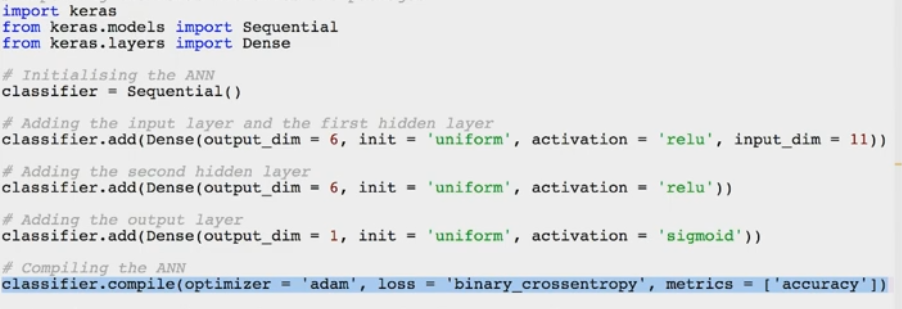

# initilize artificial Nerual network 
classifier = Sequential()

# add input layer and first hiddern layer 

#classifier.add(Dense(units = 128, activation='relu'))

classifier.add(Dense(units = 120, activation = 'relu', input_dim = X.shape[-1]))

# adding second hiddern layer with rectified linear activation 

classifier.add(Dense(units = 256, activation = 'relu'))

#adding output layer with sigmoid activation function 

classifier.add(Dense(units = 120, activation = 'sigmoid'))

# finally compiling the classifier with optimzation of adam (while gradient decent optimation can also be used)

classifier.compile(optimizer='adam',loss= 'binary_crossentropy',metrics=['accuracy'])

In [427]:
# Flip bboxes during training.
# Note: The validation loss is always quite big here because we don't flip the bounding boxes for the validation data. 
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]  # TODO: Check if its more performant if tensor elements are accessed directly below.
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]
    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U


def distance(bbox1, bbox2):
    return np.sqrt(np.sum(np.square(bbox1[:2] - bbox2[:2])))

num_epochs = 50
flipped_train_y = np.array(train_y)
flipped = np.zeros((len(flipped_train_y), num_epochs))
ious = np.zeros((len(flipped_train_y), num_epochs))
dists = np.zeros((len(flipped_train_y), num_epochs))

for epoch in range(num_epochs):
    print('Epoch', epoch)
    model.fit(train_X, flipped_train_y, validation_data=(test_X, test_y), verbose=2)
    pred_y = model.predict(train_X)

    for i, (pred_bboxes, exp_bboxes) in enumerate(zip(pred_y, flipped_train_y)):
        
        flipped_exp_bboxes = np.concatenate([exp_bboxes[4:], exp_bboxes[:4]])
        
        mse = np.mean(np.square(pred_bboxes - exp_bboxes))
        mse_flipped = np.mean(np.square(pred_bboxes - flipped_exp_bboxes))
        
        iou = IOU(pred_bboxes[:4], exp_bboxes[:4]) + IOU(pred_bboxes[4:], exp_bboxes[4:])
        iou_flipped = IOU(pred_bboxes[:4], flipped_exp_bboxes[:4]) + IOU(pred_bboxes[4:], flipped_exp_bboxes[4:])
        
        dist = distance(pred_bboxes[:4], exp_bboxes[:4]) + IOU(pred_bboxes[4:], exp_bboxes[4:])
        dist_flipped = distance(pred_bboxes[:4], flipped_exp_bboxes[:4]) + IOU(pred_bboxes[4:], flipped_exp_bboxes[4:])
        
        if mse_flipped < mse:  # using iou or dist here leads to similar results
            flipped_train_y[i] = flipped_exp_bboxes
            flipped[i, epoch] = 1
            ious[i, epoch] = iou_flipped / 2.
            dists[i, epoch] = dist_flipped / 2.
        else:
            ious[i, epoch] = iou / 2.
            dists[i, epoch] = dist / 2.
            
    print('Flipped {} training samples ({} %)'.format(np.sum(flipped[:, epoch]), np.mean(flipped[:, epoch]) * 100.))
    print('Mean IOU: {}'.format(np.mean(ious[:, epoch])))
    print('Mean dist: {}'.format(np.mean(dists[:, epoch])))
    #print

Epoch 0
13/13 - 1s - loss: 0.2625 - val_loss: 0.2454 - 1s/epoch - 82ms/step
Flipped 161.0 training samples (40.25 %)
Mean IOU: 0.0
Mean dist: 0.268684471871387
Epoch 1
13/13 - 0s - loss: 0.2302 - val_loss: 0.2447 - 201ms/epoch - 15ms/step
Flipped 71.0 training samples (17.75 %)
Mean IOU: 0.0
Mean dist: 0.2606092070619134
Epoch 2
13/13 - 0s - loss: 0.2169 - val_loss: 0.2441 - 178ms/epoch - 14ms/step
Flipped 9.0 training samples (2.25 %)
Mean IOU: 0.0
Mean dist: 0.25767501227466466
Epoch 3
13/13 - 0s - loss: 0.2155 - val_loss: 0.2434 - 176ms/epoch - 14ms/step
Flipped 1.0 training samples (0.25 %)
Mean IOU: 0.0
Mean dist: 0.2574363321400599
Epoch 4
13/13 - 0s - loss: 0.2146 - val_loss: 0.2428 - 168ms/epoch - 13ms/step
Flipped 0.0 training samples (0.0 %)
Mean IOU: 0.0
Mean dist: 0.2572013367164272
Epoch 5
13/13 - 0s - loss: 0.2140 - val_loss: 0.2422 - 176ms/epoch - 14ms/step
Flipped 0.0 training samples (0.0 %)
Mean IOU: 0.0
Mean dist: 0.2569693979899811
Epoch 6
13/13 - 0s - loss: 0.2133 

Text(0, 0.5, 'Training sample')

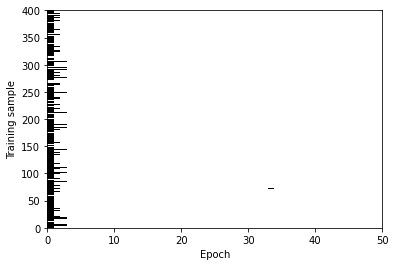

In [408]:
plt.pcolor(flipped[:1000], cmap='Greys')
plt.xlabel('Epoch')
plt.ylabel('Training sample')

(0.0, 1.0)

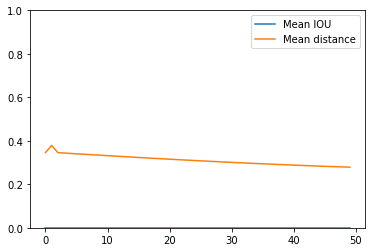

In [409]:
plt.plot(np.mean(ious, axis=0), label='Mean IOU')  # between predicted and assigned true bboxes
plt.plot(np.mean(dists, axis=0), label='Mean distance')  # relative to image size
plt.legend()
plt.ylim(0, 1)

In [410]:
pred_y = model.predict(test_X)
pred_y = pred_y.reshape(len(pred_y), num_objects, -1)
pred_bboxes = pred_y[..., :4] * img_size
pred_shapes = pred_y[..., 4:5]
pred_bboxes.shape, pred_shapes.shape

((100, 3, 4), (100, 3, 1))

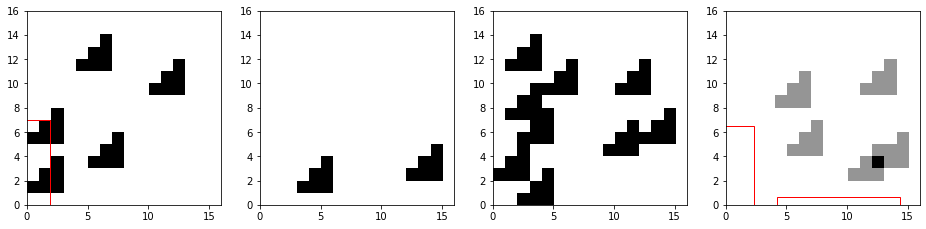

In [411]:
plt.figure(figsize=(16, 8))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_X))
    j = np.random.randint(len(test_X))
    k = np.random.randint(len(test_X))
    plt.imshow((test_imgs[i].T+test_imgs[j].T+test_imgs[k].T), cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox, pred_shape in zip(pred_bboxes[i], test_bboxes[i], pred_shapes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r' if pred_shape[0] <= 0.5 else 'y', fc='none'))
        # TODO: Calculate max IOU with all expected bounding boxes.
#         plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.4), color='r')

# plt.savefig('plots/bw-two-rectangles-or-triangles4.png', dpi=300)